# Generation of plots

This notebook generates the plots to compare the standard single-sample iMAT against CORNETO's multi-sample method. The script used to generate the `results_10reps.csv.gz` file is `script_multi_imat.py`, repeating the results using 10 different seeds

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tarfile
from io import StringIO
import numpy as np
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '../'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from util import set_default_style

set_default_style(font_scale=1.5)
#plt.rcParams['font.size'] = 14
#sns.set_style("whitegrid")

In [39]:
# Results generated using the code from 02_metabolic_network_inference, but for different lambda values and 10 different seeds
df_results = pd.read_csv("results_10reps.csv.gz", index_col=0)
df_results.head()

,fold,val_n_pos,val_n_neg,mip_gap,lambda,norel,eps,n_rxns,total_error,abs_val_err,TP,TN,FP,FN,F1,TPR_RECALL,PPV_PRECISION,seed
0,0,1170,330,0.1,0.0,1800,0.001,2030,1959.0,1601.0,353,2638,784,817,0.306,0.302,0.310,0
1,1,1217,341,0.1,0.0,1800,0.001,2090,1961.0,1586.0,367,2638,736,850,0.316,0.302,0.333,0
2,2,1130,337,0.1,0.0,1800,0.001,2128,1999.0,1581.0,320,2690,771,810,0.288,0.283,0.293,0
3,3,1154,344,0.1,0.0,1800,0.001,2100,1979.0,1574.0,354,2663,774,800,0.310,0.307,0.314,0
4,4,1181,335,0.1,0.0,1800,0.001,2078,1925.0,1670.0,302,2619,791,879,0.266,0.256,0.276,0


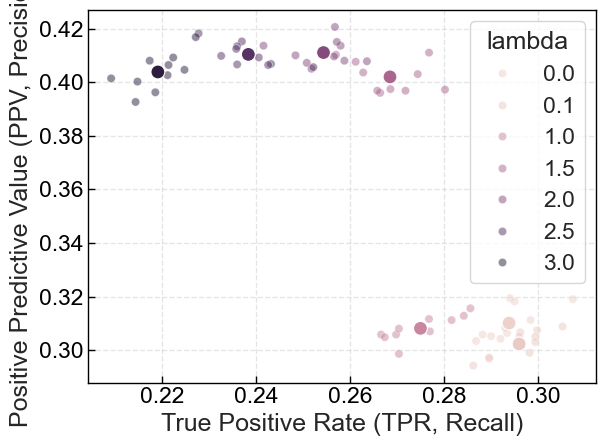

In [40]:
grouped = df_results.groupby(['lambda', 'seed']).mean().reset_index()

fig, ax = plt.subplots()
df_results = grouped.copy()
df_results["selected_lambda"] = df_results["lambda"] == 1.5
sns.scatterplot(data=df_results, x="TPR_RECALL", y="PPV_PRECISION", hue="lambda", legend="full", alpha=0.5, ax=ax)
sns.scatterplot(data=df_results.groupby("lambda").mean(), x="TPR_RECALL", y="PPV_PRECISION", hue="lambda", marker="o", s=100, legend=False, ax=ax)
ax.set_xlabel("True Positive Rate (TPR, Recall)")
ax.set_ylabel("Positive Predictive Value (PPV, Precision)")

plt.tight_layout()

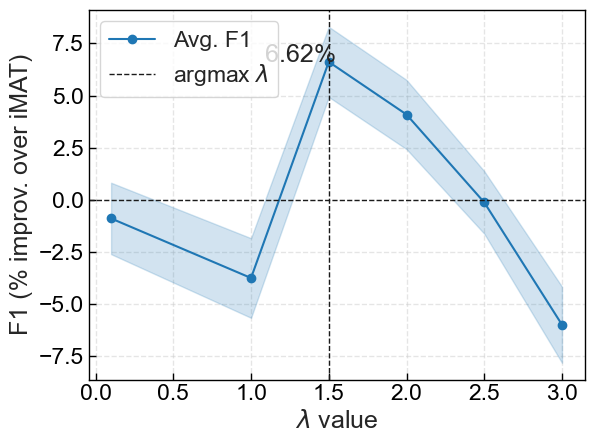

In [41]:
def plot_lines(data, target="F1", vline="argmin", target_label=None, vline_label=None, figsize=None, relative=False, ax=None):
    stats = data.groupby('lambda')[target].agg(['mean', 'std']).reset_index()
    
    if target_label is None:
        target_label = target
    
    # Calculate baseline (mean at lambda=0)
    baseline = stats.loc[stats['lambda'] == 0, 'mean'].values[0] if any(stats['lambda'] == 0) else None
    
    if relative and baseline is not None:
        # Calculate % improvement relative to baseline
        stats['mean'] = 100 * (stats['mean'] - baseline) / baseline
        # Exclude lambda=0 for plotting
        stats = stats[stats['lambda'] != 0]
    
    if ax is None:
        _, ax = plt.subplots(figsize=figsize)
    
    line, = ax.plot(stats['lambda'], stats['mean'], label=f'Avg. {target_label}', color="tab:blue", marker="o")
    
    # Add shaded area for variability (adjust for relative)
    if relative:
        stats['std'] = 100 * stats['std'] / baseline  # Convert std to % for consistency
    
    ax.fill_between(stats['lambda'], 
                    stats['mean'] - stats['std'], 
                    stats['mean'] + stats['std'], 
                    color="tab:blue", alpha=0.2)
    
    if vline is not None:
        if isinstance(vline, str):
            if vline == "argmin":
                xpos = data.loc[data[target].idxmin(), 'lambda']
                vline_label = "argmin $\lambda$"
            elif vline == "argmax":
                xpos = data.loc[data[target].idxmax(), 'lambda']
                vline_label = "argmax $\lambda$"
        else:
            xpos = vline
        ax.axvline(x=xpos, linestyle="--", color="k", linewidth=1.0, label=vline_label)
        
        if xpos in stats['lambda'].values:
            y_value = stats.loc[stats['lambda'] == xpos, 'mean'].values[0]
            point_text = f'{y_value:.2f}'
            if relative:
                point_text += '%'
            ax.annotate(point_text,
                        (xpos, y_value), 
                        textcoords="offset points",
                        xytext=(-20,0), # Distance from the text to the points (x,y)
                        ha='center') # Alignment of the text
    
    # Set labels and adjust for relative view
    ylabel = f"{target_label}"
    if relative:
        ax.axhline(y=0, linestyle="--", color="k", linewidth=1.0)
        ylabel += " (% improv. over iMAT)"
    ax.set_ylabel(ylabel)
    ax.set_xlabel("$\lambda$ value")
    ax.legend()
    #plt.tight_layout()
    #plt.show()

# Example usage
plot_lines(grouped, target="F1", vline="argmax", relative=True)
plt.savefig('output/f1_cv.pdf', format='pdf', bbox_inches='tight')

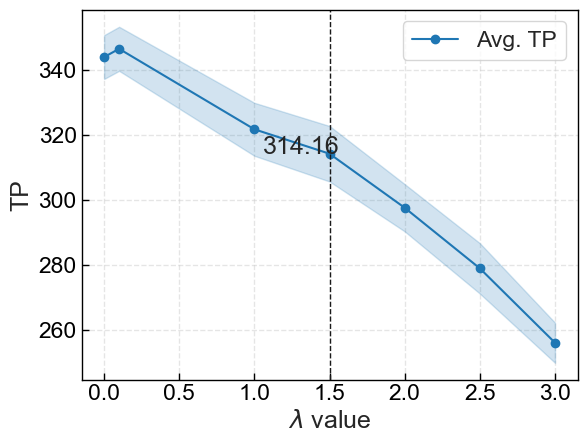

In [42]:
plot_lines(grouped, target="TP", vline=1.5, relative=False)

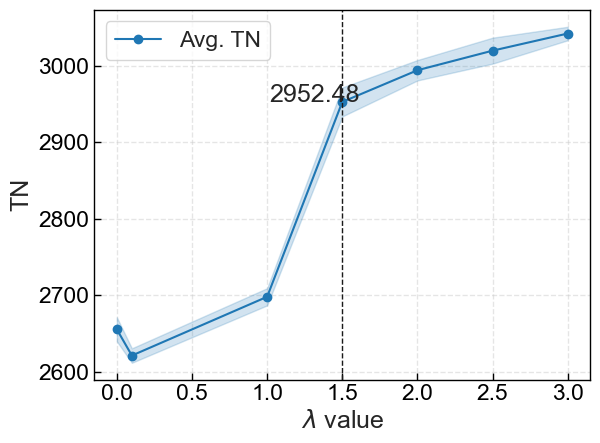

In [43]:
plot_lines(grouped, target="TN", vline=1.5, relative=False)

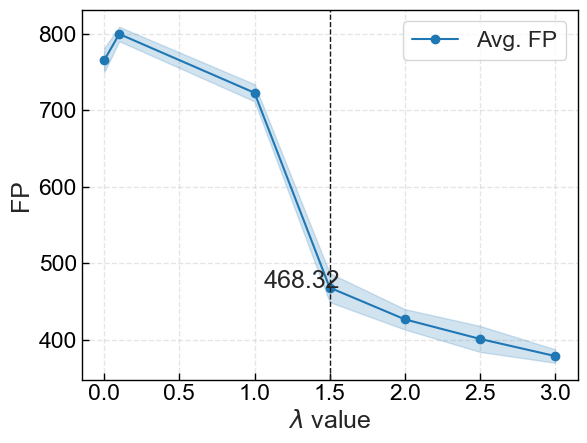

In [44]:
plot_lines(grouped, target="FP", vline=1.5, relative=False)

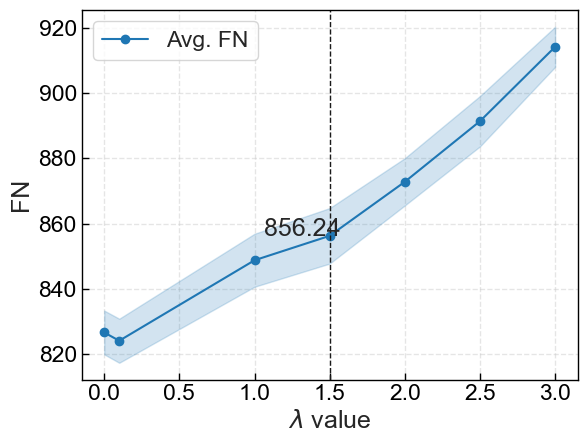

In [45]:
plot_lines(grouped, target="FN", vline=1.5, relative=False)

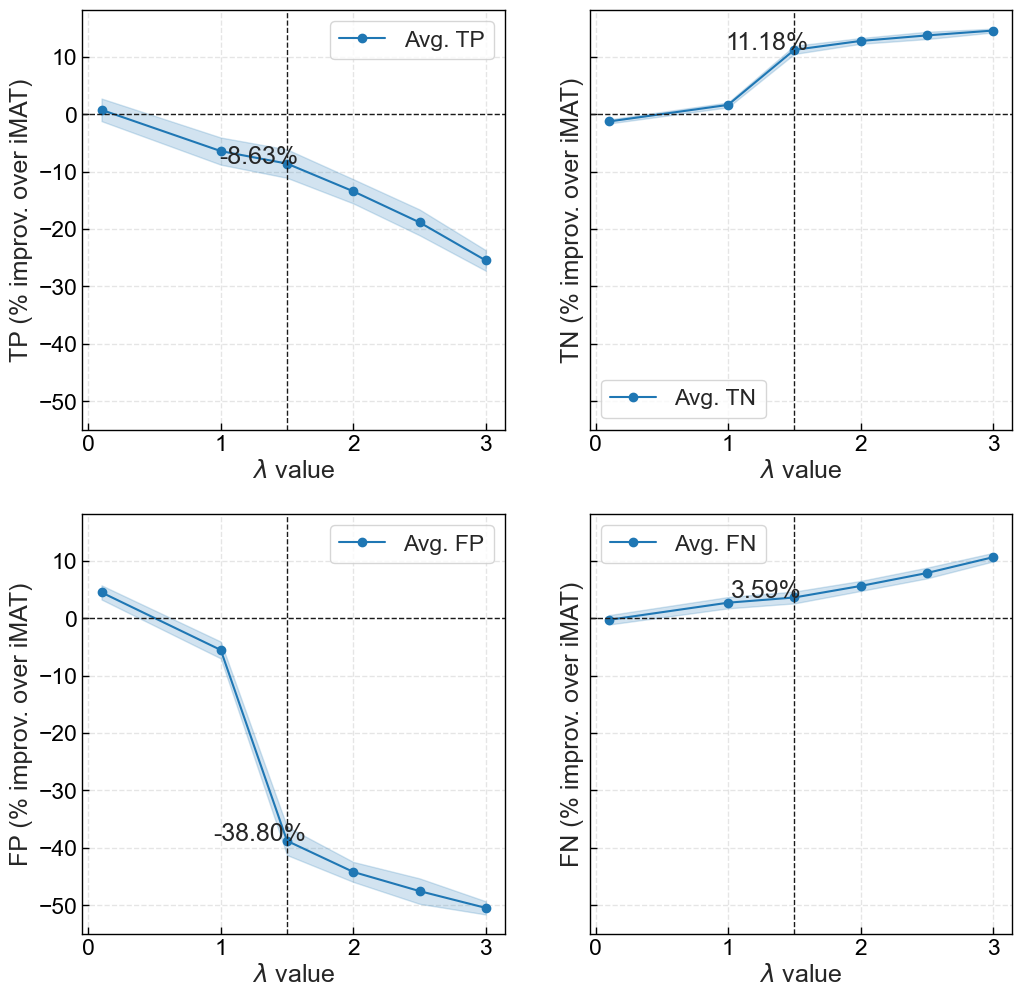

In [46]:
fig, ax = plt.subplots(2, 2, figsize=(12,12), sharey=True)
plot_lines(grouped, target="TP", vline=1.5, relative=True, ax=ax[0,0])
plot_lines(grouped, target="TN", vline=1.5, relative=True, ax=ax[0,1])
plot_lines(grouped, target="FP", vline=1.5, relative=True, ax=ax[1,0])
plot_lines(grouped, target="FN", vline=1.5, relative=True, ax=ax[1,1])
plt.savefig('output/matrix.pdf', format='pdf', bbox_inches='tight')

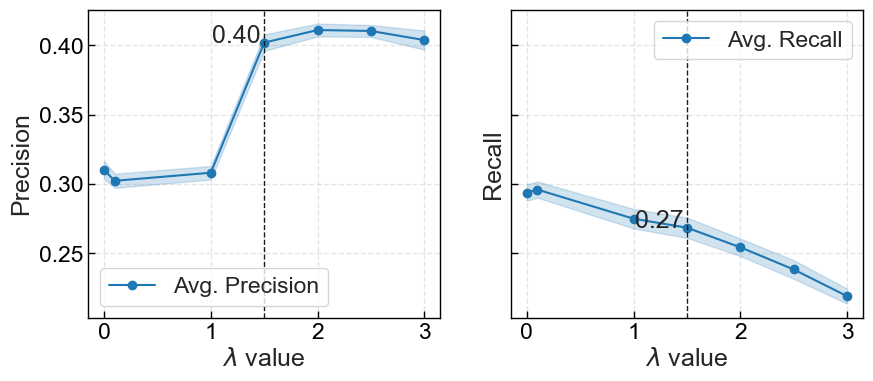

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_lines(grouped, target="PPV_PRECISION", target_label="Precision", vline=1.5, relative=False, ax=ax[0])
plot_lines(grouped, target="TPR_RECALL", target_label="Recall", vline=1.5, relative=False, ax=ax[1])

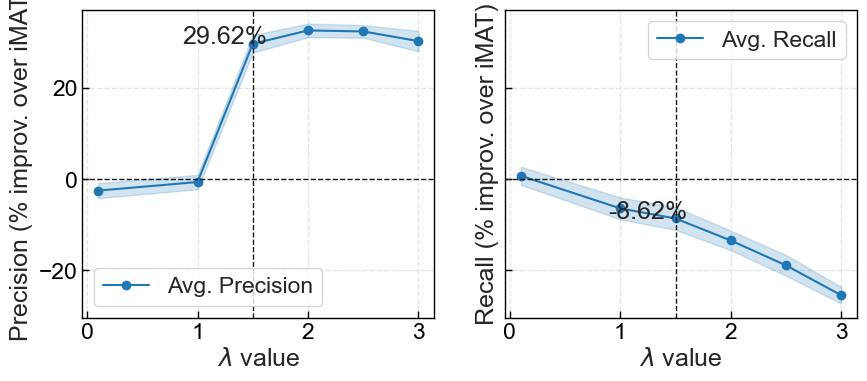

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_lines(grouped, target="PPV_PRECISION", target_label="Precision", vline=1.5, relative=True, ax=ax[0])
plot_lines(grouped, target="TPR_RECALL", target_label="Recall", vline=1.5, relative=True, ax=ax[1])

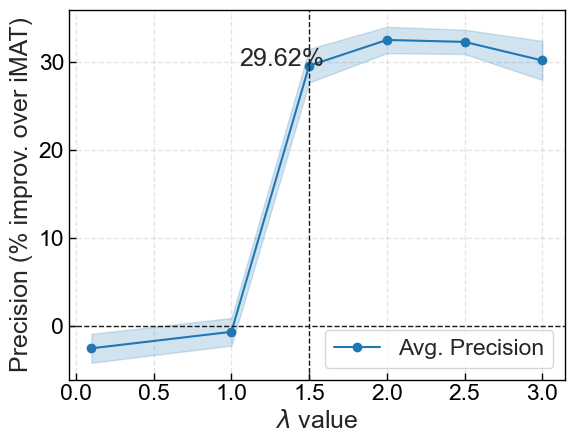

In [49]:
plot_lines(grouped, target="PPV_PRECISION", target_label="Precision", vline=1.5, relative=True)
plt.savefig('output/precision_cv.pdf', format='pdf', bbox_inches='tight')

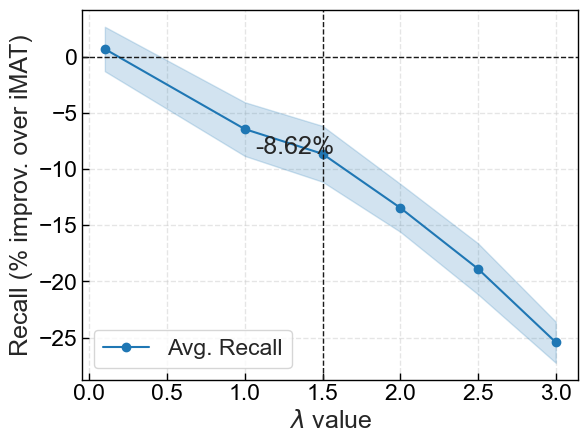

In [50]:
plot_lines(grouped, target="TPR_RECALL", target_label="Recall", vline=1.5, relative=True)
plt.savefig('output/recall_cv.pdf', format='pdf', bbox_inches='tight')

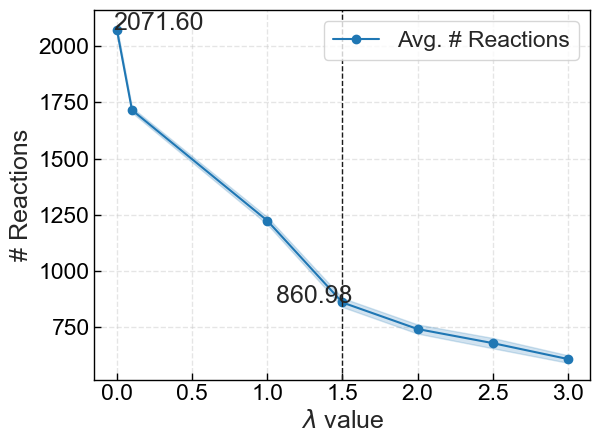

In [51]:
plot_lines(grouped, target="n_rxns", target_label="# Reactions", vline=1.5, relative=False)
mean_rxns_imat = grouped[grouped["lambda"]==0.0].n_rxns.mean()
plt.annotate(f"{mean_rxns_imat:.2f}",
            (0, mean_rxns_imat), 
            textcoords="offset points",
            xytext=(30,0), # Distance from the text to the points (x,y)
            ha='center') # Alignment of the text
plt.savefig('output/num_reacts.pdf', format='pdf', bbox_inches='tight')